# Imports

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm

In [2]:
# !pip install pandas

# Config

In [3]:
class CFG:
    seed = 888
    debug = False
    one_fold = False
    base_dir = pathlib.Path("../input/hms-harmful-brain-activity-classification")
    path_train = base_dir / "train.csv"
    spec_dir =  "EEG_Spectrograms"
    transform = transforms.Resize((768, 768), antialias=False)
    model_name = "tf_efficientnet_b0.ns_jft_in1k"
    n_fold = 5
    epochs = 10
    batch_size = 8
    lr = 0.0001  
    smooth = 0

# Load data
- We classify the spectrogram directly.
- As a label we use the aggregated the votes per spectrogram slice

In [4]:
train_df = pd.read_csv("../input/hms-harmful-brain-activity-classification/train.csv")
print('Train shape:', train_df.shape )

train_df['total_evaluators'] = train_df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)
train_df = train_df[train_df.total_evaluators>=10].reset_index(drop=True)
del train_df['total_evaluators']
train_df

Train shape: (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5
1,2277392603,1,2.0,924234,1,2.0,134339127,30539,GPD,0,0,5,0,1,5
2,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0,1,0,14,0,1
3,722738444,1,2.0,999431,1,2.0,1949834128,56885,LRDA,0,1,0,14,0,1
4,722738444,2,4.0,999431,2,4.0,3790867376,56885,LRDA,0,1,0,14,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39941,2750557840,2,10.0,2146188334,2,10.0,621803104,21884,Other,0,0,0,0,0,13
39942,3910994355,0,0.0,2146798838,0,0.0,4272062867,28488,LPD,0,9,0,2,0,7
39943,3938393892,0,0.0,2146798838,1,60.0,2587113091,28488,LPD,0,9,0,2,0,7
39944,3938393892,1,4.0,2146798838,2,64.0,827904671,28488,LPD,0,9,0,2,0,7


In [5]:
label_columns = train_df.filter(like="_vote").columns.to_list()
label_columns

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [6]:
# READ ALL SPECTROGRAMS
PATH = '../input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')
import pickle
def picklesave(obj,file):
    ff = open(file,'wb')
    pickle.dump(obj,ff)
    ff.close()

def pickleload(file):
    ff = open(file,'rb')
    obj = pickle.load(ff)
    ff.close()
    return obj



spectrograms = pickleload('../input/hms-harmful-brain-activity-classification/specs.pkl')

There are 11138 spectrogram parquets


In [8]:
len(os.listdir('../input/hms-harmful-brain-activity-classification/train_spectrograms'))

11138

In [9]:
len(os.listdir('EEG_Spectrograms'))

17089

In [10]:
TARGETS = train_df.columns[-6:]
TARGETS

Index(['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote',
       'other_vote'],
      dtype='object')

In [11]:
data = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
data.columns = ['spec_id','min']

tmp = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
data['max'] = tmp

tmp = train_df.groupby('eeg_id')[['patient_id']].agg('first')
data['patient_id'] = tmp

tmp = train_df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    data[t] = tmp[t].values
    
y_data = data[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
data[TARGETS] = y_data

tmp = train_df.groupby('eeg_id')[['expert_consensus']].agg('first')
data['target'] = tmp

data = data.reset_index()
print('Train non-overlapp eeg_id shape:', data.shape )
data["path"] = data.eeg_id.map(lambda x: f"EEG_Spectrograms/{x}.npy")

data.head()

Train non-overlapp eeg_id shape: (5939, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,path
0,568657,789577333,0.0,16.0,20654,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,Other,EEG_Spectrograms/568657.npy
1,582999,1552638400,0.0,38.0,20230,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,LPD,EEG_Spectrograms/582999.npy
2,1895581,128369999,1138.0,1138.0,47999,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,Other,EEG_Spectrograms/1895581.npy
3,2482631,978166025,1902.0,1944.0,20606,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,Other,EEG_Spectrograms/2482631.npy
4,2521897,673742515,0.0,4.0,62117,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,Other,EEG_Spectrograms/2521897.npy


In [12]:
# data = train_df.groupby(["eeg_id",'spectrogram_id'])[label_columns].sum()
# n = data.sum(axis=1)
# for x in label_columns:
#     data[x] = data[x] / n
# data = data.reset_index()

# # data["path2"] = data.spectrogram_id.map(lambda x: f"../input/hms-harmful-brain-activity-classification/train_spectrograms/{x}.parquet")
# data

# Data Handling
- Spectrogram is loaded, which contains spectrograms in 4 different regions.
- All together they are clipped, log-transformed and the standardized.
- Finally it is resized as an image.
- Note, since the spectrograms have sometimes very different lenghts this creates a certain distortion.

In [13]:
from torch.utils.data import Dataset, DataLoader
def preprocess(x):
#     x = np.clip(x, np.exp(-6), np.exp(10))
#     x = np.log(x)
    m, s = x.mean(), x.std()
    x = (x - m) / (s + 1e-6)
    return x

def preprocess2(x):
    x = np.clip(x, np.exp(-6), np.exp(10))
    x = np.log(x)
    m, s = x.mean(), x.std()
    x = (x - m) / (s + 1e-6)
    return x

In [14]:

# row = data.iloc[0]
# # input
# x = np.load(row.path)
# x = [x[:,:,i+0:i+1] for i in range(4)]
# x1 = np.concatenate(x,axis=0)[:,:,0]
# x1 = preprocess(x1)

# # input
# x = pd.read_parquet(row.path2)
# x = x.fillna(-1).values[:, 1:].T
# x2 = preprocess2(x)
# x2 = torch.Tensor(x2[None, :])
# x2 = np.array(CFG.transform(x2))[0]
# x = np.concatenate([x1,x2])

In [15]:
# plt.figure(figsize=(10,7))
# plt.imshow(x)
# plt.show()

In [16]:
data.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,path
0,568657,789577333,0.0,16.0,20654,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,Other,EEG_Spectrograms/568657.npy
1,582999,1552638400,0.0,38.0,20230,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,LPD,EEG_Spectrograms/582999.npy
2,1895581,128369999,1138.0,1138.0,47999,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,Other,EEG_Spectrograms/1895581.npy
3,2482631,978166025,1902.0,1944.0,20606,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,Other,EEG_Spectrograms/2482631.npy
4,2521897,673742515,0.0,4.0,62117,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,Other,EEG_Spectrograms/2521897.npy


In [17]:



class SpecDataset(Dataset):
    
    def __init__(self, df, transform=CFG.transform, mode='train'):
        self.df = df
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        # input
        x = np.load(row.path)
        x = [x[:,:,i+0:i+1] for i in range(6)]
        x1 = np.concatenate(x,axis=0)[:,:,0]

        x1 = preprocess(x1)
        x = spectrograms[row.spec_id]
        r = int( (row['min'] + row['max'])//4 )
        x = x[:,r:r+300]

        x2 = preprocess2(x)
        x2 = torch.Tensor(x2[None, :])
        x2 = np.array(CFG.transform(x2))[0]

        x = np.concatenate([x1,x2])

        
        x = torch.Tensor(x[None, :])
        if self.transform:
            x = self.transform(x)
        # output
        y = np.array(row.loc[label_columns].values, 'float32')
        
        if CFG.smooth and self.mode!='valid':
            factor = 0.05
            y = y * (1 - factor)
            y = y + (factor / 6)
        
        y = torch.Tensor(y)
        return x, y

In [18]:
ds = SpecDataset(df=data.iloc[:50], mode='train')
ds, len(ds)

(<__main__.SpecDataset at 0x7fc31dcce3d0>, 50)

In [20]:
x, y = ds[0]
x.shape, x, y.shape, y

(torch.Size([1, 768, 768]),
 tensor([[[ 1.4129,  1.6354,  1.7833,  ...,  1.8816,  1.8490,  1.6849],
          [ 1.4655,  1.6799,  1.8197,  ...,  1.9255,  1.8998,  1.7551],
          [ 1.3657,  1.5629,  1.6841,  ...,  1.8064,  1.7938,  1.6769],
          ...,
          [ 0.3024,  0.1690, -0.4373,  ..., -1.0130, -1.3094, -1.3746],
          [ 0.2935,  0.1754, -0.3616,  ..., -1.0857, -1.2963, -1.3426],
          [ 0.2448,  0.1393, -0.3400,  ..., -0.9603, -1.2432, -1.3054]]]),
 torch.Size([6]),
 tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.1667, 0.5833]))

In [21]:
os.cpu_count()

128

In [22]:
ld = DataLoader(dataset=ds, batch_size=CFG.batch_size, drop_last=True, num_workers=0)
ld, len(ld)

(<torch.utils.data.dataloader.DataLoader at 0x7fc31db53e20>, 6)

In [23]:
x, y = next(iter(ld))
x.shape, x, y.shape, y

(torch.Size([8, 1, 768, 768]),
 tensor([[[[ 1.4129,  1.6354,  1.7833,  ...,  1.8816,  1.8490,  1.6849],
           [ 1.4655,  1.6799,  1.8197,  ...,  1.9255,  1.8998,  1.7551],
           [ 1.3657,  1.5629,  1.6841,  ...,  1.8064,  1.7938,  1.6769],
           ...,
           [ 0.3024,  0.1690, -0.4373,  ..., -1.0130, -1.3094, -1.3746],
           [ 0.2935,  0.1754, -0.3616,  ..., -1.0857, -1.2963, -1.3426],
           [ 0.2448,  0.1393, -0.3400,  ..., -0.9603, -1.2432, -1.3054]]],
 
 
         [[[ 0.9838,  1.2073,  1.3740,  ...,  1.5839,  1.4839,  1.3884],
           [ 1.0405,  1.2500,  1.4064,  ...,  1.6082,  1.5056,  1.4247],
           [ 0.9407,  1.1220,  1.2505,  ...,  1.4377,  1.3290,  1.2811],
           ...,
           [-0.8056, -0.7937, -0.7396,  ..., -1.0486, -1.0678, -1.0720],
           [-0.7364, -0.7275, -0.6868,  ..., -1.0451, -1.0075, -0.9992],
           [-0.7405, -0.7257, -0.6583,  ..., -1.0975, -1.1557, -1.1685]]],
 
 
         [[[ 2.5914,  2.8178,  2.9558,  ...,  2.1

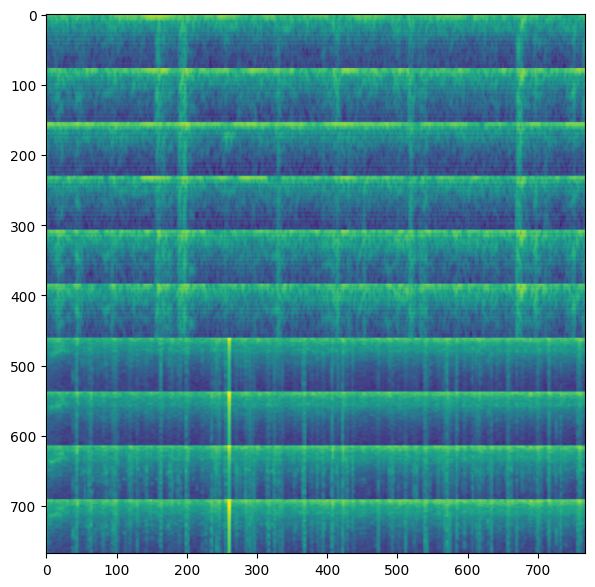

In [24]:
plt.figure(figsize=(10,7))
plt.imshow(np.array(x[0, 0].cpu()))
plt.show()

# Model

In [25]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [26]:
torch.cuda.memory_allocated()

0

In [27]:
model = timm.create_model(model_name=CFG.model_name, pretrained=False, num_classes=6, in_chans=1)
model.to(DEVICE)
num_parameter = sum(x.numel() for x in model.parameters())
print(f"Model has {num_parameter} parameters.")

Model has 4014658 parameters.


In [28]:
y_out = model(x.to(DEVICE))
y_out

tensor([[-0.7023, -0.5551,  0.6655, -2.1052,  0.9941, -0.0153],
        [-0.2270, -0.5147,  0.6683, -1.3388, -0.1651,  0.2944],
        [-0.1874, -0.8188,  0.5260, -1.9575,  0.7557,  0.3196],
        [-0.1346, -0.9576,  0.3308, -1.4054,  0.5242,  0.9044],
        [ 0.5310, -1.3182,  0.3802, -0.7271, -0.6473,  0.8427],
        [-0.9079, -0.8194,  0.2242, -2.3341,  0.4437, -0.0541],
        [ 0.4684, -1.2350,  0.3227, -2.0984,  0.7175,  1.1267],
        [-1.0072, -1.1398,  1.2167, -3.4845,  3.5857,  1.6632]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

# Training Utils
- Create Kullback-Leibler Divergence loss from logits.
- Compute loss utility.

In [29]:
def KLDivLoss(logit, target):
    log_prob = F.log_softmax(logit, dim=1)
    return F.kl_div(log_prob, target, reduction="batchmean")

In [30]:
# from reference
def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

In [31]:
KLDivLoss(y_out, y.to(DEVICE)), KL_loss(p=y.to(DEVICE), q=y_out)

(tensor(1.4187, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.4187, device='cuda:0', grad_fn=<MeanBackward0>))

In [32]:
def compute_loss(model, data_loader):
    model.eval()
    l_loss = []
    with torch.no_grad():
        for x, y in data_loader:
            y_pred = model(x.to(DEVICE))
            loss = KLDivLoss(y_pred, y.to(DEVICE))
            l_loss.append(loss.item())
    return np.mean(l_loss) 

In [33]:
compute_loss(model, ld)

1.1089864174524944

In [34]:
torch.cuda.memory_allocated()

8334444544

In [35]:
del model, x, y, y_out
torch.cuda.empty_cache()

In [36]:
torch.cuda.memory_allocated()

8334419456

# Training
- Uses plain 5 fold training strategy.
- Runs for all epochs and checkpoints model weights if the validation loss improves.

In [37]:
from sklearn.model_selection import KFold

In [38]:
if CFG.debug:
    data = data.iloc[:400]

Fold 0:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.273521, Valid Loss:   0.241246
Loss improves from        inf to   0.241246


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.233135, Valid Loss:   0.230934
Loss improves from   0.241246 to   0.230934


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.211822, Valid Loss:   0.230972


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.190693, Valid Loss:   0.234503


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.173670, Valid Loss:   0.231304


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.153625, Valid Loss:   0.235237


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.137590, Valid Loss:   0.249215


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.120128, Valid Loss:   0.243806


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.104939, Valid Loss:   0.248251


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.094898, Valid Loss:   0.251833

Best loss Model training with 0.23093398730426826



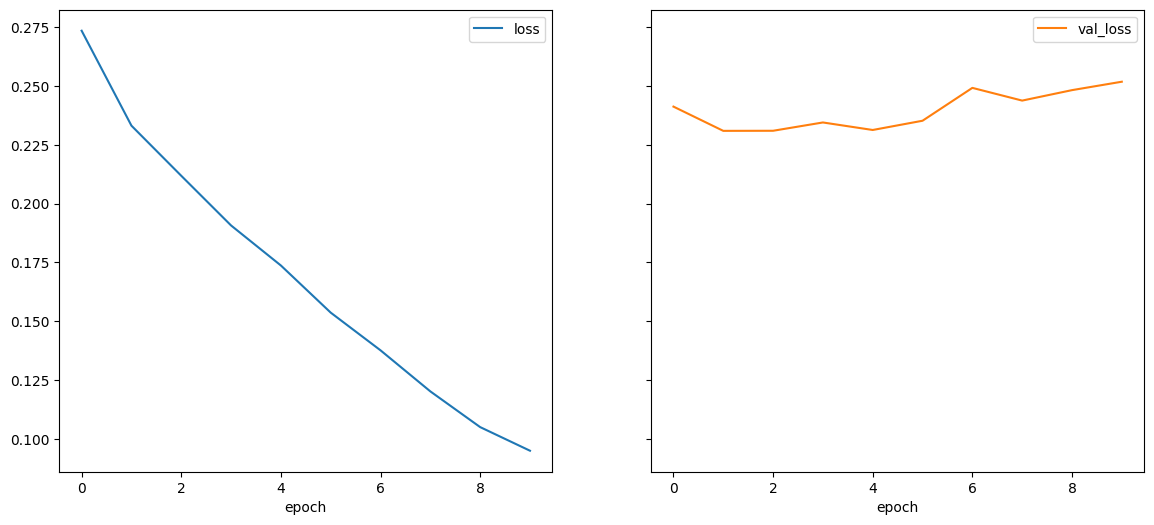

Fold 1:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.274277, Valid Loss:   0.240264
Loss improves from        inf to   0.240264


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.231716, Valid Loss:   0.237507
Loss improves from   0.240264 to   0.237507


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.211760, Valid Loss:   0.235244
Loss improves from   0.237507 to   0.235244


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.191002, Valid Loss:    0.23203
Loss improves from   0.235244 to    0.23203


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.171345, Valid Loss:   0.236527


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.155536, Valid Loss:   0.239781


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.138963, Valid Loss:    0.24931


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.121562, Valid Loss:   0.247121


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.107645, Valid Loss:   0.246364


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.095756, Valid Loss:   0.256721

Best loss Model training with 0.23202975504350343



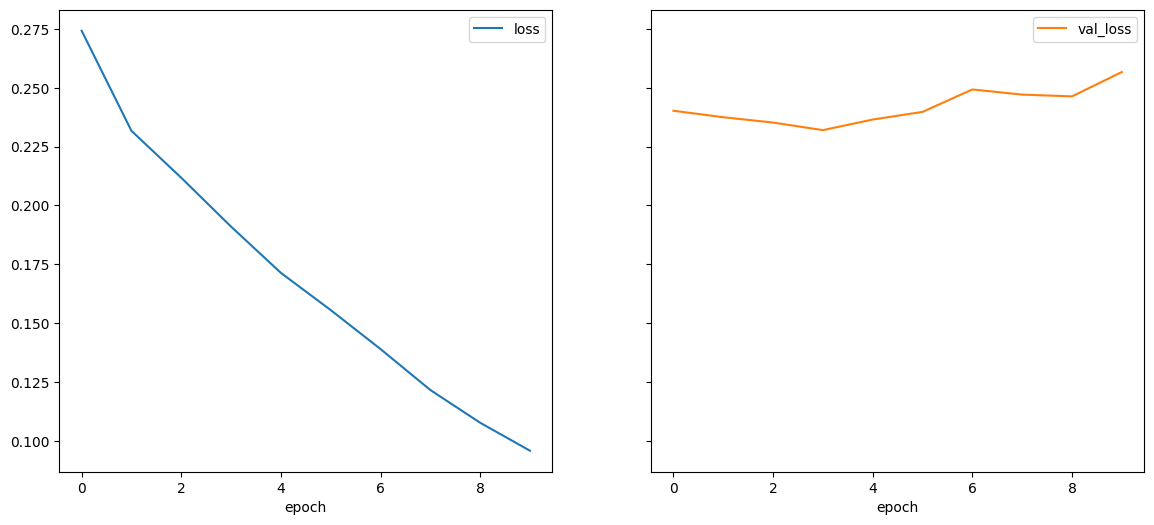

Fold 2:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.274686, Valid Loss:   0.240579
Loss improves from        inf to   0.240579


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.230635, Valid Loss:   0.232998
Loss improves from   0.240579 to   0.232998


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.212741, Valid Loss:   0.232389
Loss improves from   0.232998 to   0.232389


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.190662, Valid Loss:   0.235411


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.173432, Valid Loss:   0.234524


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.153989, Valid Loss:    0.23253


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.135204, Valid Loss:   0.236727


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.120110, Valid Loss:    0.24278


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.106174, Valid Loss:   0.246715


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.094620, Valid Loss:   0.253511

Best loss Model training with 0.2323888695280024



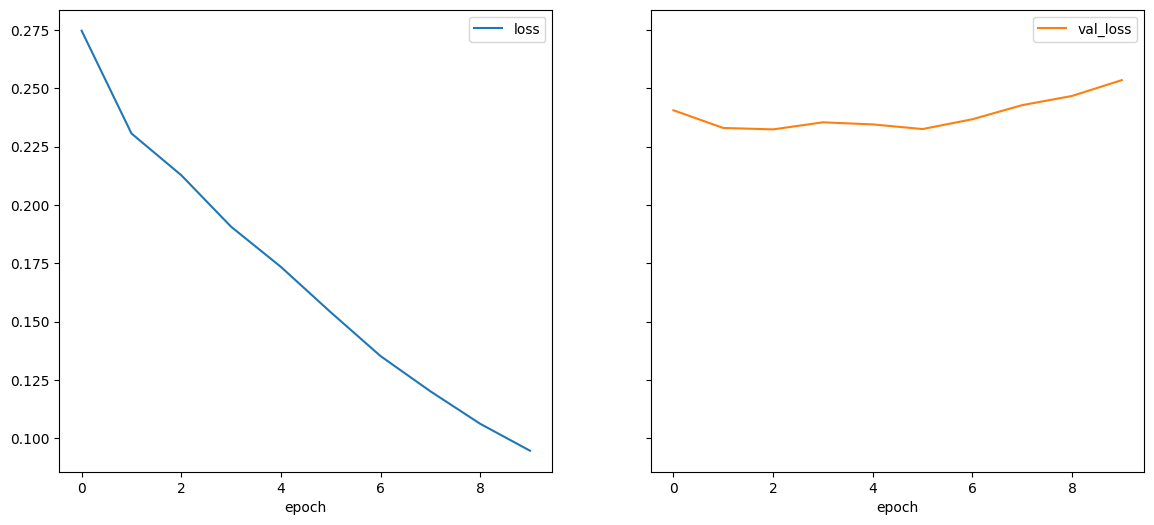

Fold 3:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.275745, Valid Loss:   0.231718
Loss improves from        inf to   0.231718


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.236015, Valid Loss:    0.22119
Loss improves from   0.231718 to    0.22119


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.215274, Valid Loss:   0.224154


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.196352, Valid Loss:    0.22141


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.181901, Valid Loss:   0.221698


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.163565, Valid Loss:   0.226177


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.146917, Valid Loss:    0.22998


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.130492, Valid Loss:   0.242736


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.116571, Valid Loss:   0.240386


  0%|          | 0/593 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.104944, Valid Loss:   0.236531

Best loss Model training with 0.22119011814962297



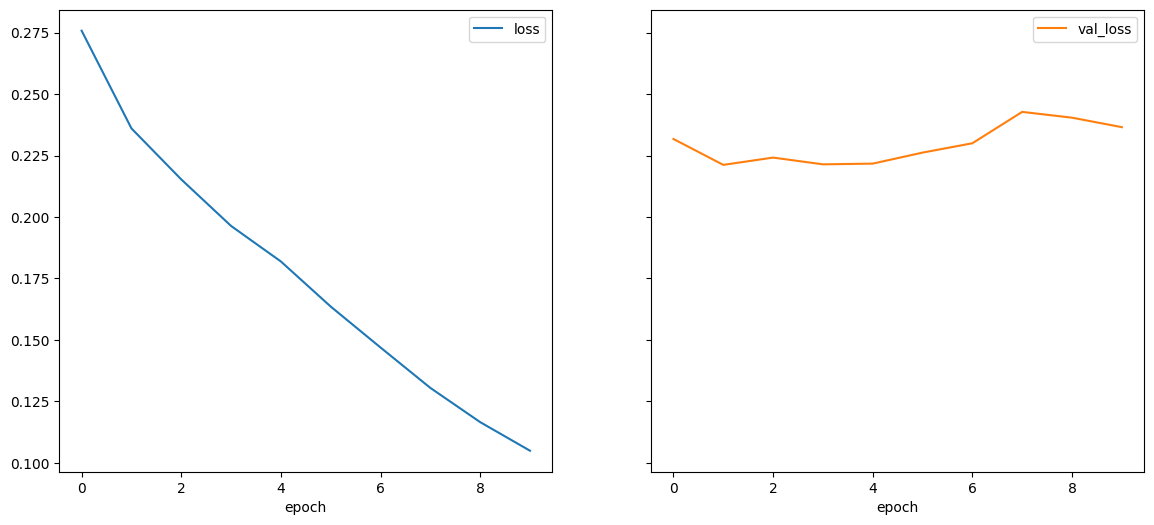

Fold 4:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.288231, Valid Loss:     0.2506
Loss improves from        inf to     0.2506


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.245818, Valid Loss:   0.241472
Loss improves from   0.250600 to   0.241472


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.219458, Valid Loss:   0.238018
Loss improves from   0.241472 to   0.238018


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.198420, Valid Loss:   0.240923


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.179623, Valid Loss:   0.239321


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.165032, Valid Loss:   0.246458


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 6
Train Loss:   0.140954, Valid Loss:   0.245176


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 7
Train Loss:   0.127354, Valid Loss:   0.257571


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 8
Train Loss:   0.112350, Valid Loss:   0.259929


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch 9
Train Loss:   0.100279, Valid Loss:   0.263349

Best loss Model training with 0.23801824565501822



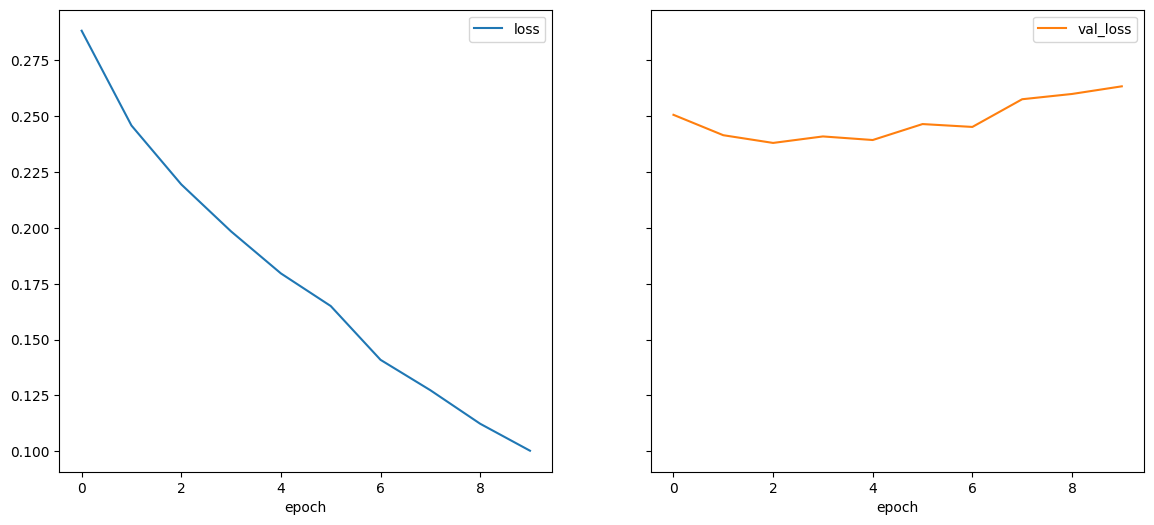

CPU times: user 11h 18min 59s, sys: 5min 6s, total: 11h 24min 5s
Wall time: 1h 9min 30s


In [39]:
%%time

kf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

l_best_loss = []
for fold, (iloc_train, iloc_valid) in enumerate(kf.split(data)):
    print(f"Fold {fold}:")

    # prepare data
    train_ds = SpecDataset(df=data.iloc[iloc_train])
    valid_ds = SpecDataset(df=data.iloc[iloc_valid], mode='valid')
    train_loader = DataLoader(dataset=train_ds, shuffle=True, batch_size=CFG.batch_size, num_workers=0, drop_last=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=CFG.batch_size, num_workers=0)
    
    # init training
    model = timm.create_model(model_name=CFG.model_name, pretrained=False, num_classes=6, in_chans=1)
    model.to(DEVICE)
    
    model.load_state_dict(torch.load(f'{CFG.model_name}_{fold}.pt'))

    
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG.epochs)
    optimizer, scheduler
    best_loss = float("inf")
    history = []
    
    # run training
    for epoch in tqdm(range(CFG.epochs)):
        model.train()
        l_loss = []
        for x, y in tqdm(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred = model(x)
            loss = KLDivLoss(y_pred, y)
            l_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss = np.mean(l_loss)
        valid_loss = compute_loss(model, valid_loader)
        history.append((epoch, train_loss, valid_loss))
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_loss:>10.6f}, Valid Loss: {valid_loss:>10.6}")
        if valid_loss < best_loss:
            print(f"Loss improves from {best_loss:>10.6f} to {valid_loss:>10.6}")
            torch.save(model.state_dict(), f"{CFG.model_name}_{fold}_v2.pt")
            best_loss = valid_loss
    print(f"\nBest loss Model training with {best_loss}\n")
    l_best_loss.append(best_loss)
    
    # plot
    history = pd.DataFrame(history, columns=["epoch", "loss", "val_loss"]).set_index("epoch")
    history.plot(subplots=True, layout=(1, 2), sharey="row", figsize=(14, 6))
    plt.show()
    
    if CFG.one_fold:
        break